# Method 9 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

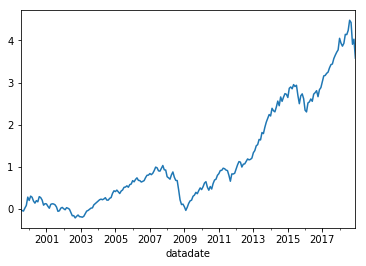

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.277254
2000-12-31   -0.121710
2001-12-31   -0.079194
2002-12-31   -0.212455
2003-12-31    0.418157
2004-12-31    0.237592
2005-12-31    0.112573
2006-12-31    0.133238
2007-12-31    0.066753
2008-12-31   -0.421307
2009-12-31    0.346387
2010-12-31    0.200005
2011-12-31    0.027007
2012-12-31    0.195931
2013-12-31    0.468891
2014-12-31    0.148312
2015-12-31   -0.028071
2016-12-31    0.072783
2017-12-31    0.231359
2018-12-31   -0.041281
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     609.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.39e-121
Time:                        20:23:01   Log-Likelihood:                 679.67
No. Observations:                 234   AIC:                            -1349.
Df Residuals:                     229   BIC:                            -1332.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.108      0.002       0.001       0.005
mktrf          0.9425      0.025     37.719      0.000       0.893       0.992
me             0.2402      0.029      8.266      0.000       0.183       0.298
ia            -0.1659      0.044     -3.756      0.000      -0.253      -0.079
roe            0.0945      0.038      2.499      0.013       0.020       0.169
==============================================================================
Omnibus:                       88.199   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1116.261
Skew:                           1.074   Prob(JB):                    4.05e-243
Kurtosis:                      13.482   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     474.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.42e-109
Time:                        20:23:01   Log-Likelihood:                 679.67
No. Observations:                 234   AIC:                            -1349.
Df Residuals:                     229   BIC:                            -1332.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.140      0.002       0.001       0.005
mktrf          0.9425      0.027     35.385      0.000       0.890       0.995
me             0.2402      0.032      7.531      0.000       0.178       0.303
ia            -0.1659      0.109     -1.527      0.127      -0.379       0.047
roe            0.0945      0.044      2.170      0.030       0.009       0.180
==============================================================================
Omnibus:                       88.199   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1116.261
Skew:                           1.074   Prob(JB):                    4.05e-243
Kurtosis:                      13.482   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     567.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.65e-117
Time:                        20:23:01   Log-Likelihood:                 679.67
No. Observations:                 234   AIC:                            -1349.
Df Residuals:                     229   BIC:                            -1332.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.817      0.005       0.001       0.005
mktrf          0.9425      0.024     39.391      0.000       0.896       0.989
me             0.2402      0.034      7.160      0.000       0.174       0.306
ia            -0.1659      0.099     -1.668      0.095      -0.361       0.029
roe            0.0945      0.040      2.379      0.017       0.017       0.172
==============================================================================
Omnibus:                       88.199   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1116.261
Skew:                           1.074   Prob(JB):                    4.05e-243
Kurtosis:                      13.482   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     444.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.18e-115
Time:                        20:23:01   Log-Likelihood:                 670.33
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     228   BIC:                            -1308.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.259      0.001       0.001       0.005
mktrf          0.9268      0.026     35.492      0.000       0.875       0.978
smb            0.2335      0.034      6.777      0.000       0.166       0.301
hml           -0.0856      0.041     -2.107      0.036      -0.166      -0.006
rmw            0.0129      0.046      0.281      0.779      -0.078       0.103
cma           -0.0323      0.058     -0.552      0.581      -0.147       0.083
==============================================================================
Omnibus:                       66.977   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.939
Skew:                           0.728   Prob(JB):                    1.42e-163
Kurtosis:                      11.649   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     620.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-130
Time:                        20:23:01   Log-Likelihood:                 670.33
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     228   BIC:                            -1308.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.896      0.004       0.001       0.005
mktrf          0.9268      0.030     30.847      0.000       0.868       0.986
smb            0.2335      0.036      6.428      0.000       0.162       0.305
hml           -0.0856      0.062     -1.377      0.169      -0.207       0.036
rmw            0.0129      0.050      0.258      0.796      -0.085       0.111
cma           -0.0323      0.131     -0.246      0.806      -0.289       0.225
==============================================================================
Omnibus:                       66.977   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.939
Skew:                           0.728   Prob(JB):                    1.42e-163
Kurtosis:                      11.649   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     735.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.07e-138
Time:                        20:23:01   Log-Likelihood:                 670.33
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     228   BIC:                            -1308.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.604      0.009       0.001       0.006
mktrf          0.9268      0.030     30.778      0.000       0.868       0.986
smb            0.2335      0.035      6.757      0.000       0.166       0.301
hml           -0.0856      0.068     -1.267      0.205      -0.218       0.047
rmw            0.0129      0.047      0.278      0.781      -0.078       0.104
cma           -0.0323      0.137     -0.236      0.813      -0.300       0.236
==============================================================================
Omnibus:                       66.977   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.939
Skew:                           0.728   Prob(JB):                    1.42e-163
Kurtosis:                      11.649   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     709.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-127
Time:                        20:23:01   Log-Likelihood:                 696.08
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.784      0.006       0.001       0.004
mktrf          1.0010      0.021     46.675      0.000       0.959       1.043
smb            0.1580      0.027      5.903      0.000       0.105       0.211
hml           -0.0201      0.027     -0.757      0.450      -0.073       0.032
umd            0.1395      0.017      7.994      0.000       0.105       0.174
==============================================================================
Omnibus:                       45.472   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.834
Skew:                           0.516   Prob(JB):                     9.50e-65
Kurtosis:                       8.401   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     686.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.11e-126
Time:                        20:23:01   Log-Likelihood:                 696.08
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.548      0.011       0.001       0.004
mktrf          1.0010      0.031     32.788      0.000       0.941       1.061
smb            0.1580      0.029      5.392      0.000       0.101       0.215
hml           -0.0201      0.052     -0.384      0.701      -0.123       0.083
umd            0.1395      0.031      4.434      0.000       0.078       0.201
==============================================================================
Omnibus:                       45.472   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.834
Skew:                           0.516   Prob(JB):                     9.50e-65
Kurtosis:                       8.401   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     744.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.07e-130
Time:                        20:23:01   Log-Likelihood:                 696.08
No. Observations:                 234   AIC:                            -1382.
Df Residuals:                     229   BIC:                            -1365.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.475      0.013       0.000       0.004
mktrf          1.0010      0.029     34.261      0.000       0.944       1.058
smb            0.1580      0.029      5.439      0.000       0.101       0.215
hml           -0.0201      0.052     -0.390      0.697      -0.121       0.081
umd            0.1395      0.031      4.483      0.000       0.079       0.200
==============================================================================
Omnibus:                       45.472   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.834
Skew:                           0.516   Prob(JB):                     9.50e-65
Kurtosis:                       8.401   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     248.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-55
Time:                        20:23:01   Log-Likelihood:                 323.53
No. Observations:                 120   AIC:                            -637.1
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.576      0.118      -0.001       0.006
mktrf          0.9773      0.043     22.736      0.000       0.892       1.062
me             0.2564      0.042      6.040      0.000       0.172       0.341
ia            -0.1476      0.066     -2.220      0.028      -0.279      -0.016
roe            0.1607      0.059      2.731      0.007       0.044       0.277
==============================================================================
Omnibus:                       51.920   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.455
Skew:                           1.220   Prob(JB):                     1.61e-80
Kurtosis:                      11.218   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     205.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.98e-51
Time:                        20:23:01   Log-Likelihood:                 323.53
No. Observations:                 120   AIC:                            -637.1
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.941      0.052   -2.44e-05       0.005
mktrf          0.9773      0.043     22.496      0.000       0.892       1.062
me             0.2564      0.040      6.348      0.000       0.177       0.336
ia            -0.1476      0.136     -1.084      0.278      -0.414       0.119
roe            0.1607      0.050      3.234      0.001       0.063       0.258
==============================================================================
Omnibus:                       51.920   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.455
Skew:                           1.220   Prob(JB):                     1.61e-80
Kurtosis:                      11.218   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     274.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.54e-58
Time:                        20:23:01   Log-Likelihood:                 323.53
No. Observations:                 120   AIC:                            -637.1
Df Residuals:                     115   BIC:                            -623.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.831      0.067      -0.000       0.005
mktrf          0.9773      0.034     29.019      0.000       0.911       1.043
me             0.2564      0.042      6.126      0.000       0.174       0.338
ia            -0.1476      0.122     -1.205      0.228      -0.388       0.092
roe            0.1607      0.034      4.751      0.000       0.094       0.227
==============================================================================
Omnibus:                       51.920   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.455
Skew:                           1.220   Prob(JB):                     1.61e-80
Kurtosis:                      11.218   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     171.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.96e-51
Time:                        20:23:01   Log-Likelihood:                 315.88
No. Observations:                 120   AIC:                            -619.8
Df Residuals:                     114   BIC:                            -603.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.072      0.041       0.000       0.007
mktrf          0.9558      0.049     19.698      0.000       0.860       1.052
smb            0.2475      0.055      4.505      0.000       0.139       0.356
hml           -0.1193      0.067     -1.771      0.079      -0.253       0.014
rmw            0.0628      0.079      0.791      0.430      -0.094       0.220
cma            0.0345      0.087      0.396      0.693      -0.138       0.207
==============================================================================
Omnibus:                       31.612   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.656
Skew:                           0.675   Prob(JB):                     3.93e-37
Kurtosis:                       8.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     217.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.53e-56
Time:                        20:23:01   Log-Likelihood:                 315.88
No. Observations:                 120   AIC:                            -619.8
Df Residuals:                     114   BIC:                            -603.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.076      0.038       0.000       0.007
mktrf          0.9558      0.060     15.980      0.000       0.839       1.073
smb            0.2475      0.053      4.651      0.000       0.143       0.352
hml           -0.1193      0.100     -1.197      0.231      -0.315       0.076
rmw            0.0628      0.090      0.701      0.483      -0.113       0.238
cma            0.0345      0.162      0.213      0.831      -0.282       0.351
==============================================================================
Omnibus:                       31.612   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.656
Skew:                           0.675   Prob(JB):                     3.93e-37
Kurtosis:                       8.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     235.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-58
Time:                        20:23:01   Log-Likelihood:                 315.88
No. Observations:                 120   AIC:                            -619.8
Df Residuals:                     114   BIC:                            -603.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.889      0.059      -0.000       0.007
mktrf          0.9558      0.059     16.139      0.000       0.840       1.072
smb            0.2475      0.047      5.256      0.000       0.155       0.340
hml           -0.1193      0.109     -1.099      0.272      -0.332       0.093
rmw            0.0628      0.089      0.709      0.478      -0.111       0.237
cma            0.0345      0.167      0.206      0.837      -0.293       0.362
==============================================================================
Omnibus:                       31.612   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.656
Skew:                           0.675   Prob(JB):                     3.93e-37
Kurtosis:                       8.631   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     312.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.40e-61
Time:                        20:23:01   Log-Likelihood:                 335.87
No. Observations:                 120   AIC:                            -661.7
Df Residuals:                     115   BIC:                            -647.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.580      0.011       0.001       0.006
mktrf          1.0491      0.034     30.705      0.000       0.981       1.117
smb            0.1264      0.039      3.249      0.002       0.049       0.203
hml           -0.0057      0.039     -0.146      0.884      -0.083       0.071
umd            0.1705      0.024      7.096      0.000       0.123       0.218
==============================================================================
Omnibus:                       18.463   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.106
Skew:                           0.333   Prob(JB):                     1.63e-15
Kurtosis:                       6.630   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     504.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.32e-72
Time:                        20:23:01   Log-Likelihood:                 335.87
No. Observations:                 120   AIC:                            -661.7
Df Residuals:                     115   BIC:                            -647.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.908      0.004       0.001       0.006
mktrf          1.0491      0.041     25.591      0.000       0.969       1.129
smb            0.1264      0.034      3.748      0.000       0.060       0.192
hml           -0.0057      0.062     -0.092      0.926      -0.127       0.115
umd            0.1705      0.034      4.979      0.000       0.103       0.238
==============================================================================
Omnibus:                       18.463   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.106
Skew:                           0.333   Prob(JB):                     1.63e-15
Kurtosis:                       6.630   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     893.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-85
Time:                        20:23:01   Log-Likelihood:                 335.87
No. Observations:                 120   AIC:                            -661.7
Df Residuals:                     115   BIC:                            -647.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.049      0.002       0.001       0.006
mktrf          1.0491      0.033     32.093      0.000       0.985       1.113
smb            0.1264      0.028      4.468      0.000       0.071       0.182
hml           -0.0057      0.059     -0.096      0.923      -0.122       0.110
umd            0.1705      0.028      6.190      0.000       0.116       0.224
==============================================================================
Omnibus:                       18.463   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.106
Skew:                           0.333   Prob(JB):                     1.63e-15
Kurtosis:                       6.630   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     587.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.35e-73
Time:                        20:23:01   Log-Likelihood:                 388.80
No. Observations:                 114   AIC:                            -767.6
Df Residuals:                     109   BIC:                            -753.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.129      0.000       0.002       0.005
mktrf          0.9221      0.024     38.377      0.000       0.874       0.970
me             0.1999      0.037      5.388      0.000       0.126       0.273
ia            -0.2732      0.051     -5.310      0.000      -0.375      -0.171
roe           -0.0951      0.045     -2.104      0.038      -0.185      -0.006
==============================================================================
Omnibus:                        1.914   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.437
Skew:                           0.034   Prob(JB):                        0.488
Kurtosis:                       2.454   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     895.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-82
Time:                        20:23:01   Log-Likelihood:                 388.80
No. Observations:                 114   AIC:                            -767.6
Df Residuals:                     109   BIC:                            -753.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.897      0.004       0.001       0.006
mktrf          0.9221      0.019     49.122      0.000       0.885       0.959
me             0.1999      0.039      5.089      0.000       0.123       0.277
ia            -0.2732      0.061     -4.465      0.000      -0.393      -0.153
roe           -0.0951      0.054     -1.754      0.079      -0.201       0.011
==============================================================================
Omnibus:                        1.914   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.437
Skew:                           0.034   Prob(JB):                        0.488
Kurtosis:                       2.454   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1300.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.88e-91
Time:                        20:23:01   Log-Likelihood:                 388.80
No. Observations:                 114   AIC:                            -767.6
Df Residuals:                     109   BIC:                            -753.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.428      0.015       0.001       0.006
mktrf          0.9221      0.018     50.524      0.000       0.886       0.958
me             0.1999      0.039      5.160      0.000       0.124       0.276
ia            -0.2732      0.063     -4.342      0.000      -0.397      -0.150
roe           -0.0951      0.048     -1.972      0.049      -0.190      -0.001
==============================================================================
Omnibus:                        1.914   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.437
Skew:                           0.034   Prob(JB):                        0.488
Kurtosis:                       2.454   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     562.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-75
Time:                        20:23:01   Log-Likelihood:                 399.11
No. Observations:                 114   AIC:                            -786.2
Df Residuals:                     108   BIC:                            -769.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.326      0.001       0.001       0.004
mktrf          0.9290      0.021     44.178      0.000       0.887       0.971
smb            0.1847      0.034      5.411      0.000       0.117       0.252
hml           -0.0836      0.044     -1.920      0.057      -0.170       0.003
rmw           -0.1835      0.053     -3.443      0.001      -0.289      -0.078
cma           -0.2083      0.068     -3.078      0.003      -0.342      -0.074
==============================================================================
Omnibus:                        1.747   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.349
Skew:                          -0.007   Prob(JB):                        0.510
Kurtosis:                       2.467   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     615.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-77
Time:                        20:23:01   Log-Likelihood:                 399.11
No. Observations:                 114   AIC:                            -786.2
Df Residuals:                     108   BIC:                            -769.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.463      0.014       0.001       0.004
mktrf          0.9290      0.019     49.046      0.000       0.892       0.966
smb            0.1847      0.030      6.227      0.000       0.127       0.243
hml           -0.0836      0.039     -2.169      0.030      -0.159      -0.008
rmw           -0.1835      0.052     -3.557      0.000      -0.285      -0.082
cma           -0.2083      0.079     -2.623      0.009      -0.364      -0.053
==============================================================================
Omnibus:                        1.747   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.349
Skew:                          -0.007   Prob(JB):                        0.510
Kurtosis:                       2.467   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     583.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.08e-76
Time:                        20:23:01   Log-Likelihood:                 399.11
No. Observations:                 114   AIC:                            -786.2
Df Residuals:                     108   BIC:                            -769.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.010      0.044     6.2e-05       0.005
mktrf          0.9290      0.020     46.823      0.000       0.890       0.968
smb            0.1847      0.029      6.446      0.000       0.129       0.241
hml           -0.0836      0.036     -2.333      0.020      -0.154      -0.013
rmw           -0.1835      0.057     -3.209      0.001      -0.296      -0.071
cma           -0.2083      0.069     -3.026      0.002      -0.343      -0.073
==============================================================================
Omnibus:                        1.747   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.349
Skew:                          -0.007   Prob(JB):                        0.510
Kurtosis:                       2.467   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     581.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-72
Time:                        20:23:02   Log-Likelihood:                 388.19
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     109   BIC:                            -752.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.046      0.043    5.19e-05       0.003
mktrf          0.9541      0.023     41.684      0.000       0.909       0.999
smb            0.2228      0.036      6.242      0.000       0.152       0.294
hml           -0.1158      0.037     -3.149      0.002      -0.189      -0.043
umd            0.0347      0.028      1.251      0.213      -0.020       0.090
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.438
Skew:                          -0.143   Prob(JB):                        0.803
Kurtosis:                       2.896   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     950.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.84e-84
Time:                        20:23:02   Log-Likelihood:                 388.19
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     109   BIC:                            -752.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.596      0.110      -0.000       0.004
mktrf          0.9541      0.016     58.092      0.000       0.922       0.986
smb            0.2228      0.037      5.967      0.000       0.150       0.296
hml           -0.1158      0.030     -3.880      0.000      -0.174      -0.057
umd            0.0347      0.021      1.619      0.105      -0.007       0.077
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.438
Skew:                          -0.143   Prob(JB):                        0.803
Kurtosis:                       2.896   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.78e-94
Time:                        20:23:02   Log-Likelihood:                 388.19
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     109   BIC:                            -752.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.387      0.166      -0.001       0.004
mktrf          0.9541      0.016     60.915      0.000       0.923       0.985
smb            0.2228      0.041      5.465      0.000       0.143       0.303
hml           -0.1158      0.028     -4.181      0.000      -0.170      -0.061
umd            0.0347      0.024      1.472      0.141      -0.012       0.081
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.438
Skew:                          -0.143   Prob(JB):                        0.803
Kurtosis:                       2.896   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""